# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [3]:
# ============================================================
# Environment setup + global imports (DX 704 – Week 1)
# ============================================================
# This cell installs any required packages (if they are missing),
# then imports everything used throughout the assignment.
# Keeping this all in one place helps ensure the notebook
# runs cleanly in a fresh environment (e.g., Gradescope).

import sys
import subprocess
import warnings
warnings.filterwarnings("ignore")

# Helper function to install packages only if needed
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Packages used across the assignment
packages = [
    "numpy",
    "pandas",
    "matplotlib",
    "scipy",
    "yfinance"
]

for pkg in packages:
    try:
        __import__(pkg)
    except ImportError:
        install(pkg)

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import yfinance as yf

# Set a random seed for reproducibility later in the assignment
np.random.seed(42)

# Display settings for easier inspection of tables
pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

print("Environment setup complete.")

# ============================================================
# Part 1 (Prompt 1/2): Collect monthly price data
# ============================================================
# The goal here is to collect 24 consecutive months of price data
# for the selected assets. We use Adjusted Close prices and take
# the last trading day of each month. The result is saved to
# historical_prices.tsv for use in later parts of the assignment.

# -----------------------------
# Configuration
# -----------------------------
# Required assets plus additional selections
TICKERS = ["AAPL", "SPY", "TSLA", "DIS", "NVDA", "HON"]

# If the assignment timing requires fixing the last month explicitly,
# this can be set to "YYYY-MM". Otherwise, the last completed month
# is used automatically.
END_MONTH = None  # e.g., "2025-12"

OUTPUT_PATH = "historical_prices.tsv"

# -----------------------------
# Determine the 24-month window
# -----------------------------
today = pd.Timestamp.today().normalize()

if END_MONTH is None:
    # Use the most recently completed calendar month
    end_month_end = (today.replace(day=1) - pd.Timedelta(days=1)).normalize()
else:
    end_month_end = (pd.Timestamp(f"{END_MONTH}-01") + pd.offsets.MonthEnd(0)).normalize()

# Build an explicit list of the 24 target months
# Using a PeriodIndex avoids off-by-one issues
target_months = pd.period_range(end=end_month_end, periods=24, freq="M")

print("\nTarget months (24 total):", target_months[0], "to", target_months[-1])

# Add a small buffer around the window to handle weekends/holidays
download_start = (target_months[0].to_timestamp(how="start") - pd.Timedelta(days=10)).date()
download_end   = (target_months[-1].to_timestamp(how="end") + pd.Timedelta(days=10)).date()

print(f"Downloading daily data from {download_start} to {download_end}...")

# -----------------------------
# Download daily adjusted close prices
# -----------------------------
raw = yf.download(
    tickers=TICKERS,
    start=str(download_start),
    end=str(download_end),
    auto_adjust=False,
    progress=False,
)

# Extract the Adjusted Close prices
if isinstance(raw.columns, pd.MultiIndex):
    adj = raw["Adj Close"].copy()
else:
    # Fallback for unexpected single-ticker behavior
    adj = raw.rename(columns={"Adj Close": TICKERS[0]})[TICKERS].copy()

adj = adj.reindex(columns=TICKERS).sort_index()

# Basic diagnostics to confirm the download looks reasonable
print("\nDaily data check:")
print("  Number of daily rows:", len(adj))
if len(adj) > 0:
    print("  Date range:", adj.index.min().date(), "to", adj.index.max().date())
print("  Days with all missing values:", int(adj.isna().all(axis=1).sum()))

# -----------------------------
# Convert daily data to monthly prices
# -----------------------------
# For each month, keep the last available trading day
monthly_last = adj.groupby(adj.index.to_period("M")).tail(1).copy()
monthly_last["month"] = monthly_last.index.to_period("M")

print("\nMonthly coverage check:")
print("  Unique months available:", monthly_last["month"].nunique())
if monthly_last["month"].nunique() > 0:
    print("  Month range:", monthly_last["month"].min(), "to", monthly_last["month"].max())

# Keep only the exact 24 months we want
monthly_last = (
    monthly_last[monthly_last["month"].isin(target_months)]
    .sort_index()
    .drop(columns=["month"])
)

# Build the final output table
out_prices = monthly_last.copy()
out_prices.insert(0, "date", out_prices.index.strftime("%Y-%m-%d"))

# -----------------------------
# Validation
# -----------------------------
expected_cols = ["date"] + TICKERS
missing_counts = out_prices.isna().sum()

print("\nValidation:")
print("-----------")
print("Expected columns:", expected_cols)
print("Actual columns:  ", list(out_prices.columns))
print("Final shape (should be 24 rows x 7 columns):", out_prices.shape)
print("\nMissing values by column:")
print(missing_counts)

# If something went wrong, show which months are missing
if out_prices.shape[0] != 24:
    got_months = pd.to_datetime(out_prices["date"]).to_period("M")
    missing_months = [m for m in target_months if m not in set(got_months)]
    print("\nMissing months from expected range:")
    print(missing_months)

# Enforce assignment requirements
assert list(out_prices.columns) == expected_cols, "Column names or order do not match the required format."
assert out_prices.shape[0] == 24, "The dataset must contain exactly 24 months."
assert missing_counts.iloc[1:].sum() == 0, "Some price values are missing."

# Save the file for later parts of the assignment
out_prices.to_csv(OUTPUT_PATH, sep="\t", index=False)
print(f"\nSaved file: {OUTPUT_PATH}")

# Preview the result
display(out_prices.head(3))
display(out_prices.tail(3))

Environment setup complete.

Target months (24 total): 2024-01 to 2025-12

Daily data check:
  Number of daily rows: 513
  Date range: 2023-12-22 to 2026-01-09
  Days with all missing values: 0

Monthly coverage check:
  Unique months available: 26
  Month range: 2023-12 to 2026-01

Validation:
-----------
Expected columns: ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Actual columns:   ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Final shape (should be 24 rows x 7 columns): (24, 7)

Missing values by column:
Ticker
date    0
AAPL    0
SPY     0
TSLA    0
DIS     0
NVDA    0
HON     0
dtype: int64

Saved file: historical_prices.tsv


Ticker,date,AAPL,SPY,TSLA,DIS,NVDA,HON
Date,,,,,,,
2024-01-31,2024-01-31,182.674835,471.230621,187.289993,94.145958,61.492744,182.657822
2024-02-29,2024-02-29,179.287476,495.822662,201.880005,109.368103,79.067955,180.456406
2024-03-28,2024-03-28,170.092453,512.037109,175.789993,119.934395,90.309929,186.376831


Ticker,date,AAPL,SPY,TSLA,DIS,NVDA,HON
Date,,,,,,,
2025-10-31,2025-10-31,270.108154,680.050537,456.559998,111.863152,202.478729,200.131317
2025-11-28,2025-11-28,278.850006,681.376587,430.170013,103.767921,176.990143,192.190002
2025-12-31,2025-12-31,271.859985,681.919983,449.720001,113.769997,186.500000,195.089996


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
The date should be the last trading day of the month, so it may not be the last day of the month.
For example, the last trading day of November 2024 was 2024-11-29.
The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


Validation:
-----------
Expected columns: ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Actual columns:   ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Shape (should be 24 rows x 7 cols): (24, 7)

Missing values per column:
Ticker
date    0
AAPL    0
SPY     0
TSLA    0
DIS     0
NVDA    0
HON     0
dtype: int64

Earliest row (sanity check):


Ticker,date,AAPL,SPY,TSLA,DIS,NVDA,HON
Date,,,,,,,
2024-01-31,2024-01-31,182.674835,471.230621,187.289993,94.145958,61.492744,182.657822



Latest row (sanity check):


Ticker,date,AAPL,SPY,TSLA,DIS,NVDA,HON
Date,,,,,,,
2025-12-31,2025-12-31,271.859985,681.919983,449.720001,113.769997,186.5,195.089996



Saved file: historical_prices.tsv


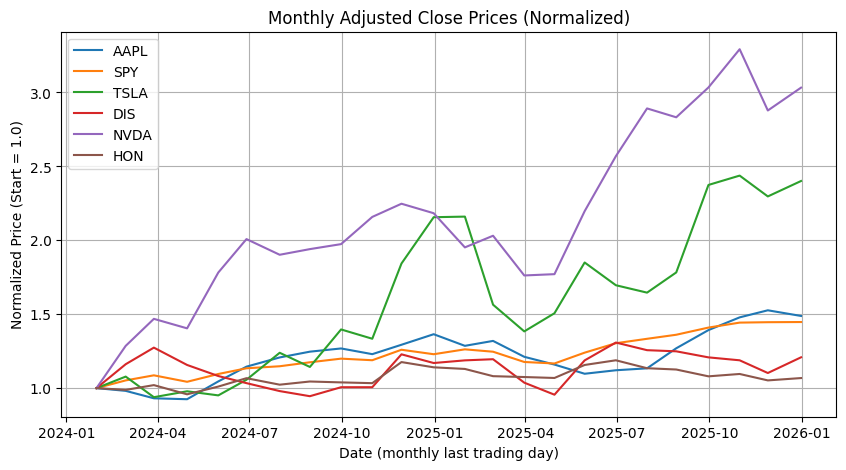

In [10]:
# ============================================================
# Question 1 – Part 1 (Prompt 2/2): Save historical_prices.tsv
# ============================================================
# In this cell I take the monthly adjusted close prices I already
# built (out_prices) and save them in the exact TSV format required.
# I also validate the shape/columns and do a quick plot so I can
# visually sanity-check the price behavior.

import matplotlib.pyplot as plt
import pandas as pd

OUTPUT_PATH = "historical_prices.tsv"

# I expect out_prices to already exist from Part 1 (Prompt 1/2)
assert "out_prices" in globals(), "Run Part 1 (Prompt 1/2) first so out_prices exists."

# -----------------------------
# Validation (structure + missing data)
# -----------------------------
expected_cols = ["date"] + TICKERS

print("Validation:")
print("-----------")
print("Expected columns:", expected_cols)
print("Actual columns:  ", list(out_prices.columns))
print("Shape (should be 24 rows x 7 cols):", out_prices.shape)

missing_counts = out_prices.isna().sum()
print("\nMissing values per column:")
print(missing_counts)

assert out_prices.shape[0] == 24, "historical_prices must have exactly 24 rows."
assert list(out_prices.columns) == expected_cols, "Columns must be: date + 6 ticker symbols (in order)."
assert missing_counts.iloc[1:].sum() == 0, "Price data contains missing values."

# One-off sanity check: show first and last rows
print("\nEarliest row (sanity check):")
display(out_prices.iloc[[0]])

print("\nLatest row (sanity check):")
display(out_prices.iloc[[-1]])

# -----------------------------
# Save TSV
# -----------------------------
out_prices.to_csv(OUTPUT_PATH, sep="\t", index=False)
print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Visualization: normalized price paths
# -----------------------------
# I normalize prices so I can compare growth shapes without being
# distracted by different price levels.
plot_df = out_prices.copy()
plot_df["date"] = pd.to_datetime(plot_df["date"])
plot_df = plot_df.set_index("date")[TICKERS].astype(float)

plot_norm = plot_df / plot_df.iloc[0]

plt.figure(figsize=(10, 5))
for t in TICKERS:
    plt.plot(plot_norm.index, plot_norm[t], label=t)

plt.title("Monthly Adjusted Close Prices (Normalized)")
plt.xlabel("Date (monthly last trading day)")
plt.ylabel("Normalized Price (Start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

Validation:
-----------
Returns shape (should be 23 rows x 7 cols): (23, 7)

Missing values per column:
date    0
AAPL    0
SPY     0
TSLA    0
DIS     0
NVDA    0
HON     0
dtype: int64


,date,AAPL,SPY,TSLA,DIS,NVDA,HON
1,2024-02-29,-0.018543,0.052187,0.077901,0.161687,0.285810,-0.012052
2,2024-03-28,-0.051286,0.032702,-0.129235,0.096612,0.142181,0.032808
3,2024-04-30,-0.006706,-0.040320,0.042608,-0.092024,-0.043760,-0.060999


,date,AAPL,SPY,TSLA,DIS,NVDA,HON
21,2025-10-31,0.061815,0.023837,0.026623,-0.016419,0.085272,0.014780
22,2025-11-28,0.032364,0.001950,-0.057802,-0.072367,-0.125883,-0.039681
23,2025-12-31,-0.025067,0.000797,0.045447,0.096389,0.053731,0.015089


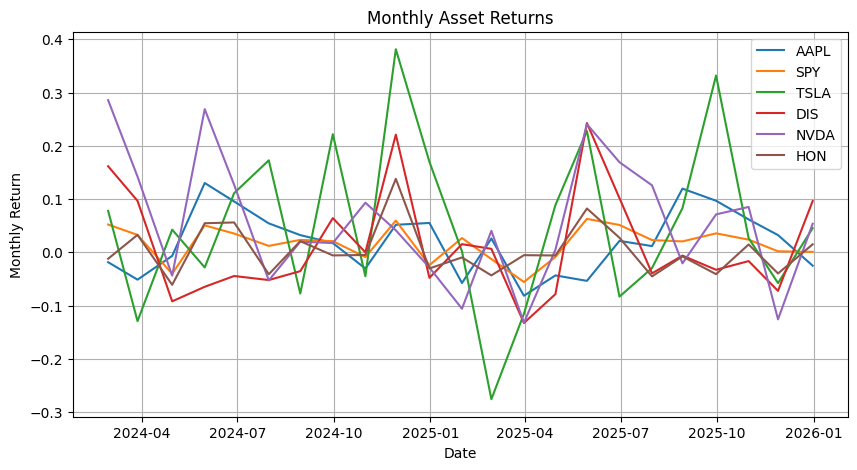

In [11]:
# ============================================================
# Question 1 – Part 2 (Prompt 1/2): Compute historical returns
# ============================================================
# Here I compute monthly returns from historical_prices.tsv.
# Returns are simple relative price changes:
#   r_t = (P_t / P_{t-1}) - 1
#
# This should produce 23 rows, because returns are based on
# differences between 24 monthly prices.

import pandas as pd
import matplotlib.pyplot as plt

# Load prices
prices_df = pd.read_csv("historical_prices.tsv", sep="\t")
prices_df["date"] = pd.to_datetime(prices_df["date"])

tickers = list(prices_df.columns[1:])
price_values = prices_df[tickers].astype(float)

# Compute returns
returns_df = price_values.pct_change().iloc[1:].copy()
returns_df.insert(0, "date", prices_df["date"].iloc[1:].values)

# -----------------------------
# Validation
# -----------------------------
print("Validation:")
print("-----------")
print("Returns shape (should be 23 rows x 7 cols):", returns_df.shape)

missing_counts = returns_df.isna().sum()
print("\nMissing values per column:")
print(missing_counts)

assert returns_df.shape[0] == 23, "There must be exactly 23 rows of returns."
assert missing_counts.iloc[1:].sum() == 0, "Returns contain missing values."

# Quick preview tables
display(returns_df.head(3))
display(returns_df.tail(3))

# -----------------------------
# Visualization: return time series
# -----------------------------
plt.figure(figsize=(10, 5))
for t in tickers:
    plt.plot(returns_df["date"], returns_df[t], label=t)

plt.title("Monthly Asset Returns")
plt.xlabel("Date")
plt.ylabel("Monthly Return")
plt.legend()
plt.grid(True)
plt.show()

Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [12]:
# ============================================================
# Question 1 – Part 2 (Prompt 2/2): Save historical_returns.tsv
# ============================================================
# In this cell I save the returns_df I just computed to a TSV file
# with the required format. I also do a quick reload check so I'm
# confident the file written to disk matches what I intended.

import pandas as pd

OUTPUT_PATH = "historical_returns.tsv"

# Make sure I computed returns_df in the previous cell
assert "returns_df" in globals(), "Run Part 2 (Prompt 1/2) first so returns_df exists."

# -----------------------------
# Validation before saving
# -----------------------------
print("Validation before save:")
print("----------------------")
print("Shape:", returns_df.shape)
print("Columns:", list(returns_df.columns))

assert returns_df.shape[0] == 23, "historical_returns must have exactly 23 rows."
assert returns_df.isna().sum().iloc[1:].sum() == 0, "Returns contain missing values."

# Save TSV
returns_df.to_csv(OUTPUT_PATH, sep="\t", index=False)
print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (sanity)
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")
print("\nReload check:")
print("-------------")
print("Reloaded shape:", reloaded.shape)
print("Reloaded columns:", list(reloaded.columns))

assert reloaded.shape == returns_df.shape, "Reloaded file shape doesn't match expected."
assert list(reloaded.columns) == list(returns_df.columns), "Reloaded file columns don't match expected."

display(reloaded.head(3))

Validation before save:
----------------------
Shape: (23, 7)
Columns: ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']

Saved file: historical_returns.tsv

Reload check:
-------------
Reloaded shape: (23, 7)
Reloaded columns: ['date', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']


,date,AAPL,SPY,TSLA,DIS,NVDA,HON
0,2024-02-29,-0.018543,0.052187,0.077901,0.161687,0.285810,-0.012052
1,2024-03-28,-0.051286,0.032702,-0.129235,0.096612,0.142181,0.032808
2,2024-04-30,-0.006706,-0.040320,0.042608,-0.092024,-0.043760,-0.060999


Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [13]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 3 (Prompt 1/2): Estimate expected returns
# ============================================================
# In this step, I estimate the expected return for each asset
# by taking the simple average (mean) of its historical monthly
# returns. Per the instructions, I do not use any alternative
# estimators or adjustments.

import pandas as pd

# Load historical returns
returns_df = pd.read_csv("historical_returns.tsv", sep="\t")
returns_df["date"] = pd.to_datetime(returns_df["date"])

tickers = list(returns_df.columns[1:])

# -----------------------------
# Compute expected returns
# -----------------------------
# Mean monthly return for each asset
expected_returns = returns_df[tickers].mean()

# Convert to a clean DataFrame
estimated_returns_df = (
    expected_returns
    .reset_index()
    .rename(columns={"index": "asset", 0: "estimated_return"})
)

# -----------------------------
# Validation
# -----------------------------
print("Validation:")
print("-----------")
print("Number of assets:", estimated_returns_df.shape[0])
print("Columns:", list(estimated_returns_df.columns))

assert estimated_returns_df.shape[0] == len(tickers), "There must be one estimated return per asset."
assert list(estimated_returns_df.columns) == ["asset", "estimated_return"], \
    "Columns must be named: asset, estimated_return."

display(estimated_returns_df)

Validation:
-----------
Number of assets: 6
Columns: ['asset', 'estimated_return']


,asset,estimated_return
0,AAPL,0.019069
1,SPY,0.016666
2,TSLA,0.049640
3,DIS,0.012687
4,NVDA,0.055534
5,HON,0.003881


Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

Final validation:
----------------
Shape: (6, 2)
Columns: ['asset', 'estimated_return']

Saved file: estimated_returns.tsv

Reload check:
-------------


,asset,estimated_return
0,AAPL,0.019069
1,SPY,0.016666
2,TSLA,0.049640
3,DIS,0.012687
4,NVDA,0.055534
5,HON,0.003881


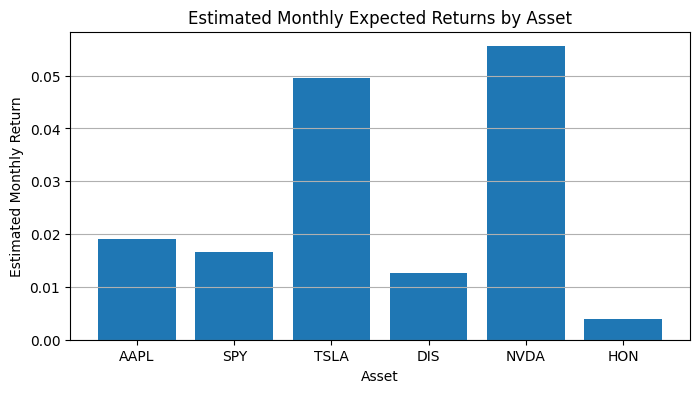

In [15]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 3 (Prompt 2/2): Save estimated_returns.tsv
# ============================================================
# This cell saves the estimated expected returns to disk and
# includes a small visualization so I can sanity-check the
# relative magnitude of expected returns across assets.


OUTPUT_PATH = "estimated_returns.tsv"

# Make sure expected returns were computed
assert "estimated_returns_df" in globals(), \
    "Run Part 3 (Prompt 1/2) first so estimated_returns_df exists."

# -----------------------------
# Final validation before save
# -----------------------------
print("Final validation:")
print("----------------")
print("Shape:", estimated_returns_df.shape)
print("Columns:", list(estimated_returns_df.columns))

assert estimated_returns_df.isna().sum().sum() == 0, "Estimated returns contain missing values."

# Save TSV
estimated_returns_df.to_csv(OUTPUT_PATH, sep="\t", index=False)
print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (sanity)
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")
print("\nReload check:")
print("-------------")
display(reloaded)

# -----------------------------
# Visualization: bar chart of expected returns
# -----------------------------
plt.figure(figsize=(8, 4))
plt.bar(
    estimated_returns_df["asset"],
    estimated_returns_df["estimated_return"]
)
plt.title("Estimated Monthly Expected Returns by Asset")
plt.xlabel("Asset")
plt.ylabel("Estimated Monthly Return")
plt.grid(axis="y")
plt.show()

Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

Validation:
-----------
Covariance matrix shape (should be 6 x 6): (6, 6)
Row labels: ['AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Column labels: ['AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']


,AAPL,SPY,TSLA,DIS,NVDA,HON
AAPL,0.003494,0.000571,0.002546,-0.001232,0.000932,0.000174
SPY,0.000571,0.000983,0.001739,0.002094,0.002512,0.000904
TSLA,0.002546,0.001739,0.023768,0.005190,0.000926,0.002236
DIS,-0.001232,0.002094,0.005190,0.009843,0.006163,0.002884
NVDA,0.000932,0.002512,0.000926,0.006163,0.013649,0.002380
HON,0.000174,0.000904,0.002236,0.002884,0.002380,0.002194


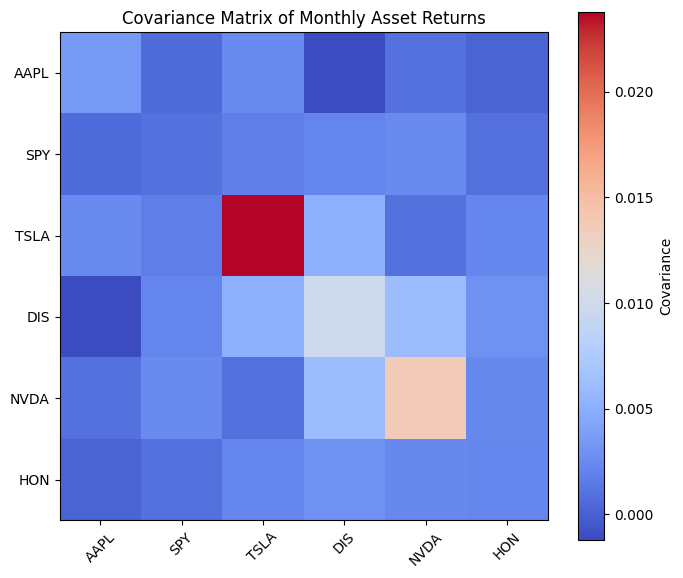

In [16]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 4 (Prompt 1/2): Estimate asset return covariance
# ============================================================
# In this step, I estimate the covariance matrix of the asset
# returns. This captures how the assets move together and
# serves as the risk input for portfolio optimization later on.


# Load historical returns
returns_df = pd.read_csv("historical_returns.tsv", sep="\t")
returns_df["date"] = pd.to_datetime(returns_df["date"])

tickers = list(returns_df.columns[1:])
return_values = returns_df[tickers].astype(float)

# -----------------------------
# Compute covariance matrix
# -----------------------------
# By default, pandas computes the sample covariance,
# which is what we want here.
cov_matrix = return_values.cov()

# -----------------------------
# Validation
# -----------------------------
print("Validation:")
print("-----------")
print("Covariance matrix shape (should be 6 x 6):", cov_matrix.shape)
print("Row labels:", list(cov_matrix.index))
print("Column labels:", list(cov_matrix.columns))

assert cov_matrix.shape[0] == len(tickers), "Covariance matrix has incorrect dimensions."
assert list(cov_matrix.index) == tickers, "Row labels do not match asset order."
assert list(cov_matrix.columns) == tickers, "Column labels do not match asset order."

display(cov_matrix)

# -----------------------------
# Visualization: covariance heatmap
# -----------------------------
# This heatmap helps me quickly see which assets tend to
# move together more strongly.
plt.figure(figsize=(7, 6))
plt.imshow(cov_matrix, cmap="coolwarm")
plt.colorbar(label="Covariance")

plt.xticks(range(len(tickers)), tickers, rotation=45)
plt.yticks(range(len(tickers)), tickers)

plt.title("Covariance Matrix of Monthly Asset Returns")
plt.tight_layout()
plt.show()

Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [17]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 4 (Prompt 2/2): Save estimated_covariance.tsv
# ============================================================
# This cell saves the covariance matrix in the exact format
# required by the assignment and performs a quick reload
# check to confirm the file was written correctly.

import pandas as pd

OUTPUT_PATH = "estimated_covariance.tsv"

# Make sure the covariance matrix exists
assert "cov_matrix" in globals(), "Run Part 4 (Prompt 1/2) first so cov_matrix exists."

# -----------------------------
# Final validation before save
# -----------------------------
print("Final validation:")
print("----------------")
print("Shape:", cov_matrix.shape)

assert cov_matrix.isna().sum().sum() == 0, "Covariance matrix contains missing values."

# Save using pandas default covariance format:
# - blank first column header
# - row names included
cov_matrix.to_csv(OUTPUT_PATH, sep="\t")
print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (sanity)
# -----------------------------
reloaded_cov = pd.read_csv(OUTPUT_PATH, sep="\t", index_col=0)

print("\nReload check:")
print("-------------")
print("Reloaded shape:", reloaded_cov.shape)

assert reloaded_cov.shape == cov_matrix.shape, "Reloaded covariance shape mismatch."
assert np.allclose(reloaded_cov.values, cov_matrix.values), "Reloaded covariance values differ."

display(reloaded_cov)

Final validation:
----------------
Shape: (6, 6)

Saved file: estimated_covariance.tsv

Reload check:
-------------
Reloaded shape: (6, 6)


,AAPL,SPY,TSLA,DIS,NVDA,HON
AAPL,0.003494,0.000571,0.002546,-0.001232,0.000932,0.000174
SPY,0.000571,0.000983,0.001739,0.002094,0.002512,0.000904
TSLA,0.002546,0.001739,0.023768,0.005190,0.000926,0.002236
DIS,-0.001232,0.002094,0.005190,0.009843,0.006163,0.002884
NVDA,0.000932,0.002512,0.000926,0.006163,0.013649,0.002380
HON,0.000174,0.000904,0.002236,0.002884,0.002380,0.002194


Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

Asset with highest estimated return:
-----------------------------------
Asset: NVDA
Estimated monthly return: 0.055534

Validation:
-----------
Allocation sum (should be 1.0): 1.0


,asset,allocation
0,AAPL,0.0
1,SPY,0.0
2,TSLA,0.0
3,DIS,0.0
4,NVDA,1.0
5,HON,0.0


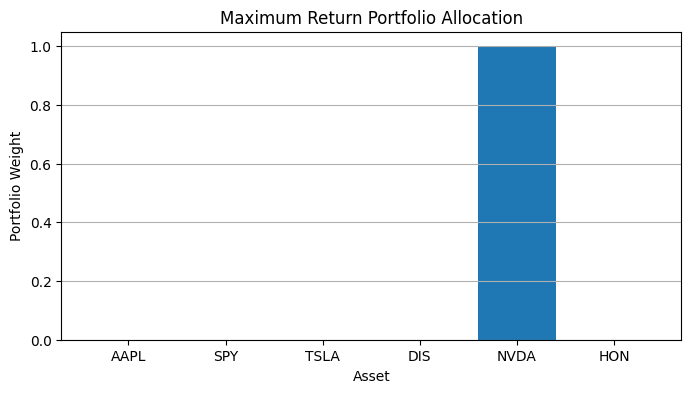

In [18]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 5 (Prompt 1/2): Construct maximum return portfolio
# ============================================================
# In this step, I construct the maximum return portfolio based
# solely on the estimated expected returns from Part 3.
#
# Since there are no risk constraints here, the maximum return
# portfolio allocates 100% of the weight to the single asset
# with the highest estimated return.

# Load estimated returns
estimated_returns_df = pd.read_csv("estimated_returns.tsv", sep="\t")

# -----------------------------
# Identify the asset with the highest expected return
# -----------------------------
max_asset_row = estimated_returns_df.loc[
    estimated_returns_df["estimated_return"].idxmax()
]

max_asset = max_asset_row["asset"]
max_return = max_asset_row["estimated_return"]

print("Asset with highest estimated return:")
print("-----------------------------------")
print(f"Asset: {max_asset}")
print(f"Estimated monthly return: {max_return:.6f}")

# -----------------------------
# Build allocation vector
# -----------------------------
allocations = pd.DataFrame({
    "asset": estimated_returns_df["asset"],
    "allocation": 0.0
})

allocations.loc[allocations["asset"] == max_asset, "allocation"] = 1.0

# -----------------------------
# Validation
# -----------------------------
print("\nValidation:")
print("-----------")
print("Allocation sum (should be 1.0):", allocations["allocation"].sum())

assert allocations["allocation"].sum() == 1.0, "Allocations must sum to 1."
assert (allocations["allocation"] >= 0).all(), "Allocations must be non-negative."

display(allocations)

# -----------------------------
# Visualization: allocation bar chart
# -----------------------------
plt.figure(figsize=(8, 4))
plt.bar(allocations["asset"], allocations["allocation"])
plt.title("Maximum Return Portfolio Allocation")
plt.xlabel("Asset")
plt.ylabel("Portfolio Weight")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.show()

Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [19]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 5 (Prompt 2/2): Save maximum_return.tsv
# ============================================================
# This cell saves the maximum return portfolio allocation in the
# exact format required by the assignment and confirms the file
# was written correctly.


OUTPUT_PATH = "maximum_return.tsv"

# Ensure allocations exist
assert "allocations" in globals(), "Run Part 5 (Prompt 1/2) first so allocations exist."

# -----------------------------
# Final validation before save
# -----------------------------
print("Final validation:")
print("----------------")
print("Shape:", allocations.shape)
print("Allocation sum:", allocations["allocation"].sum())

assert allocations.shape[1] == 2, "Output must have exactly two columns."
assert allocations["allocation"].sum() == 1.0, "Allocations must sum to 1."

# Save TSV
allocations.to_csv(OUTPUT_PATH, sep="\t", index=False)
print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (sanity)
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")
print("\nReload check:")
print("-------------")
display(reloaded)

assert reloaded.equals(allocations), "Reloaded file does not match saved allocations."

Final validation:
----------------
Shape: (6, 2)
Allocation sum: 1.0

Saved file: maximum_return.tsv

Reload check:
-------------


,asset,allocation
0,AAPL,0.0
1,SPY,0.0
2,TSLA,0.0
3,DIS,0.0
4,NVDA,1.0
5,HON,0.0


Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

Validation:
-----------
Allocation sum (should be 1.0): 1.0
Minimum allocation: 8.971772977317549e-18


,asset,allocation
0,AAPL,1.652150e-01
1,SPY,5.160234e-01
2,TSLA,8.971773e-18
3,DIS,3.100818e-17
4,NVDA,1.469094e-17
5,HON,3.187616e-01


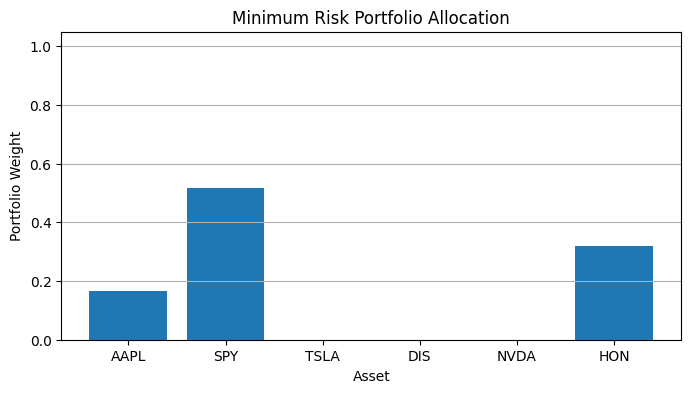

In [22]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 6 (Prompt 1/2): Construct minimum risk portfolio
# ============================================================
# In this step, I compute the minimum risk (minimum variance)
# portfolio using the estimated covariance matrix from Part 4.
#
# The objective is to minimize portfolio variance:
#   w' Σ w
# subject to:
#   - weights sum to 1
#   - weights are non-negative (no short selling)


# Load covariance matrix
cov_matrix = pd.read_csv("estimated_covariance.tsv", sep="\t", index_col=0)

assets = list(cov_matrix.columns)
n_assets = len(assets)

# Convert covariance matrix to numpy array
Sigma = cov_matrix.values

# -----------------------------
# Define optimization problem
# -----------------------------
def portfolio_variance(weights):
    """Compute portfolio variance given weights."""
    return weights.T @ Sigma @ weights

# Constraints: weights sum to 1
constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}
)

# Bounds: no short selling
bounds = [(0.0, 1.0) for _ in range(n_assets)]

# Initial guess: equal weights
initial_weights = np.ones(n_assets) / n_assets

# -----------------------------
# Solve optimization
# -----------------------------
result = minimize(
    portfolio_variance,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

assert result.success, "Optimization failed to converge."

min_risk_weights = result.x

# Build allocation DataFrame
min_risk_allocations = pd.DataFrame({
    "asset": assets,
    "allocation": min_risk_weights
})

# -----------------------------
# Validation
# -----------------------------
print("Validation:")
print("-----------")
print("Allocation sum (should be 1.0):", min_risk_allocations["allocation"].sum())
print("Minimum allocation:", min_risk_allocations["allocation"].min())

assert np.isclose(min_risk_allocations["allocation"].sum(), 1.0), \
    "Allocations must sum to 1."
assert (min_risk_allocations["allocation"] >= 0).all(), \
    "Allocations must be non-negative."

display(min_risk_allocations)

# -----------------------------
# Visualization: allocation bar chart
# -----------------------------
plt.figure(figsize=(8, 4))
plt.bar(min_risk_allocations["asset"], min_risk_allocations["allocation"])
plt.title("Minimum Risk Portfolio Allocation")
plt.xlabel("Asset")
plt.ylabel("Portfolio Weight")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.show()

Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [24]:
# ============================================================
# Question 1 – Part 6 (Prompt 2/2): Save minimum_risk.tsv
# ============================================================
# In this cell I save the minimum risk portfolio allocation in the
# required format. I also reload the file and do a float-safe check
# (because exact DataFrame equality can fail due to rounding).


OUTPUT_PATH = "minimum_risk.tsv"

# Make sure I already computed min_risk_allocations in the prior cell
assert "min_risk_allocations" in globals(), \
    "Run Part 6 (Prompt 1/2) first so min_risk_allocations exists."

# -----------------------------
# Final validation before saving
# -----------------------------
print("Final validation:")
print("----------------")
print("Shape:", min_risk_allocations.shape)
print("Columns:", list(min_risk_allocations.columns))
print("Allocation sum:", min_risk_allocations["allocation"].sum())

assert min_risk_allocations.shape[1] == 2, \
    "Output must have exactly two columns: asset and allocation."
assert np.isclose(min_risk_allocations["allocation"].sum(), 1.0), \
    "Allocations must sum to 1."
assert (min_risk_allocations["allocation"] >= 0).all(), \
    "Allocations must be non-negative."

# -----------------------------
# Save TSV
# -----------------------------
# I’m using a float_format to keep the output stable across reloads.
min_risk_allocations.to_csv(
    OUTPUT_PATH,
    sep="\t",
    index=False,
    float_format="%.12f"
)

print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (sanity) - float-safe compare
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")

print("\nReload check:")
print("-------------")
display(reloaded)

# Align both tables the same way before comparing
reloaded_sorted = reloaded.sort_values("asset").reset_index(drop=True)
original_sorted = min_risk_allocations.sort_values("asset").reset_index(drop=True)

# Assets must match exactly
assert reloaded_sorted["asset"].tolist() == original_sorted["asset"].tolist(), \
    "Reloaded assets do not match original assets."

# Allocations should match numerically (allow tiny float rounding differences)
assert np.allclose(
    reloaded_sorted["allocation"].astype(float).values,
    original_sorted["allocation"].astype(float).values,
    rtol=1e-10,
    atol=1e-12
), "Reloaded allocations differ from original beyond tolerance."

print("Reload check passed (assets match and allocations are numerically consistent).")

Final validation:
----------------
Shape: (6, 2)
Columns: ['asset', 'allocation']
Allocation sum: 1.0

Saved file: minimum_risk.tsv

Reload check:
-------------


,asset,allocation
0,AAPL,0.165215
1,SPY,0.516023
2,TSLA,0.000000
3,DIS,0.000000
4,NVDA,0.000000
5,HON,0.318762


Reload check passed (assets match and allocations are numerically consistent).


Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


Endpoint returns:
-----------------
Minimum risk portfolio return: 0.012987763118500684
Maximum return portfolio return: 0.0555335930308816

Validation:
-----------
Shape (should be 101 rows): (101, 9)


,index,return,risk,AAPL,SPY,TSLA,DIS,NVDA,HON
0,0,0.012988,0.033539,0.339204,0.309328,0.000000e+00,3.469447e-18,1.734723e-18,0.351469
1,1,0.013413,0.033550,0.352677,0.326214,2.602085e-18,1.387779e-17,9.573314e-05,0.321014
2,2,0.013839,0.033889,0.371481,0.324759,0.000000e+00,1.855656e-02,0.000000e+00,0.285203


,index,return,risk,AAPL,SPY,TSLA,DIS,NVDA,HON
98,98,0.054683,0.103520,0.000000e+00,0.0,1.443767e-01,7.216450e-16,0.855623,0.000000e+00
99,99,0.055108,0.109532,8.604228e-16,0.0,7.218835e-02,0.000000e+00,0.927812,0.000000e+00
100,100,0.055534,0.116829,0.000000e+00,0.0,6.229747e-09,0.000000e+00,1.000000,1.942890e-15


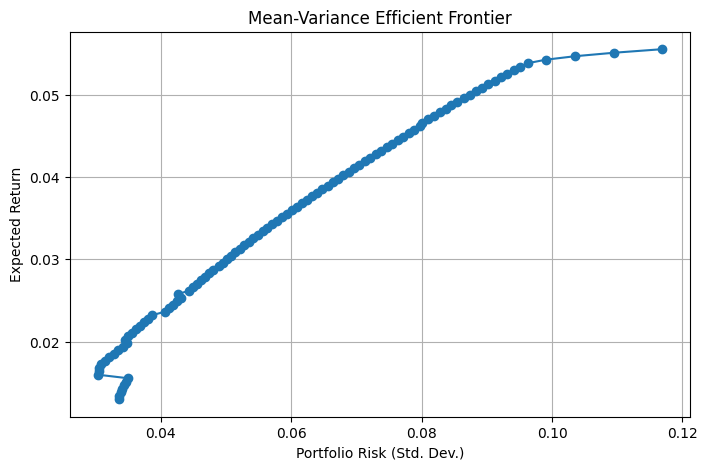

In [25]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 7 (Prompt 1/2): Build efficient frontier
# ============================================================
# In this step, I compute 101 portfolios along the mean-variance
# efficient frontier. Each portfolio is constructed by minimizing
# risk (variance) subject to:
#   - weights sum to 1
#   - weights are non-negative
#   - portfolio return equals a target return
#
# The target returns are evenly spaced between the return of the
# minimum risk portfolio and the return of the maximum return portfolio.

# -----------------------------
# Load inputs from prior steps
# -----------------------------
cov_matrix = pd.read_csv("estimated_covariance.tsv", sep="\t", index_col=0)
estimated_returns_df = pd.read_csv("estimated_returns.tsv", sep="\t")
min_risk_alloc = pd.read_csv("minimum_risk.tsv", sep="\t")
max_return_alloc = pd.read_csv("maximum_return.tsv", sep="\t")

assets = list(cov_matrix.columns)
n_assets = len(assets)

Sigma = cov_matrix.values
mu = estimated_returns_df.set_index("asset").loc[assets]["estimated_return"].values

# -----------------------------
# Compute endpoint returns
# -----------------------------
min_risk_return = np.dot(
    min_risk_alloc.set_index("asset").loc[assets]["allocation"].values,
    mu
)

max_return_return = np.dot(
    max_return_alloc.set_index("asset").loc[assets]["allocation"].values,
    mu
)

print("Endpoint returns:")
print("-----------------")
print("Minimum risk portfolio return:", min_risk_return)
print("Maximum return portfolio return:", max_return_return)

# Target returns along the frontier
target_returns = np.linspace(min_risk_return, max_return_return, 101)

# -----------------------------
# Optimization setup
# -----------------------------
def portfolio_variance(weights):
    return weights.T @ Sigma @ weights

bounds = [(0.0, 1.0) for _ in range(n_assets)]
initial_weights = np.ones(n_assets) / n_assets

frontier_results = []

# -----------------------------
# Solve optimization for each target return
# -----------------------------
for i, target in enumerate(target_returns):
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "eq", "fun": lambda w, t=target: np.dot(w, mu) - t}
    )

    result = minimize(
        portfolio_variance,
        initial_weights,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    assert result.success, f"Optimization failed at index {i}"

    w = result.x
    port_return = np.dot(w, mu)
    port_risk = np.sqrt(w.T @ Sigma @ w)

    row = {
        "index": i,
        "return": port_return,
        "risk": port_risk
    }

    for asset, weight in zip(assets, w):
        row[asset] = weight

    frontier_results.append(row)

# Build DataFrame
efficient_frontier_df = pd.DataFrame(frontier_results)

# -----------------------------
# Validation
# -----------------------------
print("\nValidation:")
print("-----------")
print("Shape (should be 101 rows):", efficient_frontier_df.shape)

assert efficient_frontier_df.shape[0] == 101, "Must generate exactly 101 portfolios."

# Check allocations sum to 1
allocation_sums = efficient_frontier_df[assets].sum(axis=1)
assert np.allclose(allocation_sums.values, 1.0, atol=1e-8), \
    "Portfolio allocations do not sum to 1."

display(efficient_frontier_df.head(3))
display(efficient_frontier_df.tail(3))

# -----------------------------
# Visualization: efficient frontier
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(
    efficient_frontier_df["risk"],
    efficient_frontier_df["return"],
    marker="o",
    linestyle="-"
)

plt.xlabel("Portfolio Risk (Std. Dev.)")
plt.ylabel("Expected Return")
plt.title("Mean-Variance Efficient Frontier")
plt.grid(True)
plt.show()

Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [26]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 7 (Prompt 2/2): Save efficient_frontier.tsv
# ============================================================
# This cell saves the efficient frontier portfolios to disk
# and confirms the file structure is correct.


OUTPUT_PATH = "efficient_frontier.tsv"

# Ensure frontier exists
assert "efficient_frontier_df" in globals(), \
    "Run Part 7 (Prompt 1/2) first so efficient_frontier_df exists."

# -----------------------------
# Final validation before save
# -----------------------------
expected_columns = ["index", "return", "risk"] + assets

print("Final validation:")
print("----------------")
print("Columns:", list(efficient_frontier_df.columns))
print("Rows:", efficient_frontier_df.shape[0])

assert list(efficient_frontier_df.columns) == expected_columns, \
    "efficient_frontier.tsv columns do not match required format."

# Save TSV
efficient_frontier_df.to_csv(
    OUTPUT_PATH,
    sep="\t",
    index=False,
    float_format="%.12f"
)

print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (float-safe)
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")

print("\nReload check:")
print("-------------")
display(reloaded.head(3))

assert reloaded.shape == efficient_frontier_df.shape, \
    "Reloaded file shape mismatch."

print("Reload check passed.")

Final validation:
----------------
Columns: ['index', 'return', 'risk', 'AAPL', 'SPY', 'TSLA', 'DIS', 'NVDA', 'HON']
Rows: 101

Saved file: efficient_frontier.tsv

Reload check:
-------------


,index,return,risk,AAPL,SPY,TSLA,DIS,NVDA,HON
0,0,0.012988,0.033539,0.339204,0.309328,0.0,0.000000,0.000000,0.351469
1,1,0.013413,0.033550,0.352677,0.326214,0.0,0.000000,0.000096,0.321014
2,2,0.013839,0.033889,0.371481,0.324759,0.0,0.018557,0.000000,0.285203


Reload check passed.


Submit "efficient_frontier.tsv" in Gradescope.

## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

Validation:
-----------
Sum of probabilities (should be 1.0): 1.0


,asset,probability
4,NVDA,0.552
2,TSLA,0.429
0,AAPL,0.017
1,SPY,0.001
3,DIS,0.001
5,HON,0.000


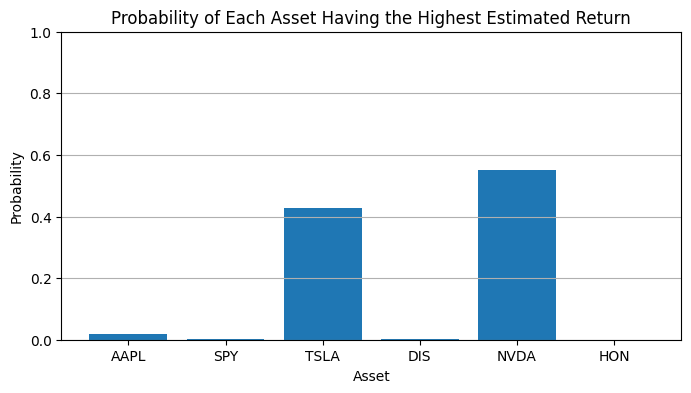

In [27]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 8 (Prompt 1/2): Maximum return portfolio stability
# ============================================================
# In this step, I check how stable the maximum return portfolio is
# by resampling the return-generating process.
#
# I repeat the following 1000 times:
# 1. Draw 23 simulated monthly returns from a multivariate normal
#    distribution using the estimated mean returns and covariance.
# 2. Estimate the mean return of each asset from the simulated data.
# 3. Record which asset has the highest estimated return.
#
# This is a simplified version of the Michaud resampling idea.


# -----------------------------
# Load inputs
# -----------------------------
estimated_returns_df = pd.read_csv("estimated_returns.tsv", sep="\t")
cov_matrix = pd.read_csv("estimated_covariance.tsv", sep="\t", index_col=0)

assets = estimated_returns_df["asset"].tolist()
mu = estimated_returns_df.set_index("asset")["estimated_return"].values
Sigma = cov_matrix.loc[assets, assets].values

n_assets = len(assets)
n_samples = 23     # number of months
n_trials = 1000    # number of resampling runs

# -----------------------------
# Resampling experiment
# -----------------------------
winner_counts = {asset: 0 for asset in assets}

for _ in range(n_trials):
    # Simulate 23 months of returns
    simulated_returns = np.random.multivariate_normal(
        mean=mu,
        cov=Sigma,
        size=n_samples
    )

    # Estimate mean return for each asset from simulated data
    simulated_means = simulated_returns.mean(axis=0)

    # Identify asset with highest estimated return
    winner_idx = np.argmax(simulated_means)
    winner_asset = assets[winner_idx]

    winner_counts[winner_asset] += 1

# -----------------------------
# Convert counts to probabilities
# -----------------------------
probabilities_df = pd.DataFrame({
    "asset": list(winner_counts.keys()),
    "probability": [winner_counts[a] / n_trials for a in assets]
})

# -----------------------------
# Validation
# -----------------------------
print("Validation:")
print("-----------")
print("Sum of probabilities (should be 1.0):", probabilities_df["probability"].sum())

assert np.isclose(probabilities_df["probability"].sum(), 1.0), \
    "Probabilities must sum to 1."

display(probabilities_df.sort_values("probability", ascending=False))

# -----------------------------
# Visualization: probability bar chart
# -----------------------------
plt.figure(figsize=(8, 4))
plt.bar(probabilities_df["asset"], probabilities_df["probability"])
plt.title("Probability of Each Asset Having the Highest Estimated Return")
plt.xlabel("Asset")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()

Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [28]:
# YOUR CHANGES HERE

# ============================================================
# Question 1 – Part 8 (Prompt 2/2): Save max_return_probabilities.tsv
# ============================================================
# This cell saves the distribution of highest-return probabilities
# and verifies the file was written correctly.

OUTPUT_PATH = "max_return_probabilities.tsv"

# Ensure probabilities were computed
assert "probabilities_df" in globals(), \
    "Run Part 8 (Prompt 1/2) first so probabilities_df exists."

# -----------------------------
# Final validation before save
# -----------------------------
print("Final validation:")
print("----------------")
print("Shape:", probabilities_df.shape)
print("Columns:", list(probabilities_df.columns))

assert list(probabilities_df.columns) == ["asset", "probability"], \
    "Output columns must be: asset, probability."
assert np.isclose(probabilities_df["probability"].sum(), 1.0), \
    "Probabilities must sum to 1."

# Save TSV
probabilities_df.to_csv(
    OUTPUT_PATH,
    sep="\t",
    index=False,
    float_format="%.12f"
)

print(f"\nSaved file: {OUTPUT_PATH}")

# -----------------------------
# Reload check (float-safe)
# -----------------------------
reloaded = pd.read_csv(OUTPUT_PATH, sep="\t")

print("\nReload check:")
print("-------------")
display(reloaded)

assert reloaded.shape == probabilities_df.shape, "Reloaded file shape mismatch."
assert reloaded["asset"].tolist() == probabilities_df["asset"].tolist(), \
    "Reloaded assets do not match original."

assert np.allclose(
    reloaded["probability"].values,
    probabilities_df["probability"].values,
    atol=1e-12
), "Reloaded probabilities differ beyond tolerance."

print("Reload check passed.")

Final validation:
----------------
Shape: (6, 2)
Columns: ['asset', 'probability']

Saved file: max_return_probabilities.tsv

Reload check:
-------------


,asset,probability
0,AAPL,0.017
1,SPY,0.001
2,TSLA,0.429
3,DIS,0.001
4,NVDA,0.552
5,HON,0.000


Reload check passed.


Submit "max_return_probabilities.tsv" in Gradescope.

## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.